In [1]:
INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/BLA_LFP_data/LFP_BLA_gamma.mat'  # True In Vivo Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'  # Pink Noise/Background
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'  # Buried Gamma in BG
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/Generated/pn_multisine_gamma.npz'  # Generated Sine in PN
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine_syn_noise.mat'  # Synthetic Feng 1000 cell model Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'  # Feng Raw 1000 cell model Data

In [2]:
from lfp_prediction.data_gathering import MatlabCollector, NumpyCollector, TextCollector

frequency_band = (55, 85)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
    del data
    del labels
dc = MatlabCollector(INVIVO_RAW_PATH)
dc.get_data()
data, labels = dc.filter_data(filter_type='non-causal',
                              freq_band=frequency_band,
                              filter_rate=400)

data = data[:10000]

19176
(36544, 1, 300)
(36544, 1, 300)


In [3]:
from sklearn.decomposition import PCA
import numpy as np
np.set_printoptions(precision=3, suppress=True)

pca = PCA()

X_new = pca.fit_transform(np.squeeze(data))
print(X_new.shape)
print(pca.components_.shape)
print(pca.explained_variance_ratio_ * 100)

(10000, 300)
(300, 300)
[17.446 16.828 10.788  8.739  7.195  6.12   5.069  4.115  3.291  2.492
  2.016  1.666  1.406  1.213  1.     0.892  0.734  0.629  0.555  0.47
  0.413  0.362  0.336  0.287  0.269  0.239  0.22   0.195  0.193  0.187
  0.184  0.182  0.179  0.176  0.175  0.171  0.166  0.165  0.162  0.161
  0.157  0.154  0.151  0.148  0.144  0.137  0.128  0.116  0.113  0.104
  0.093  0.083  0.076  0.066  0.059  0.053  0.048  0.043  0.039  0.034
  0.031  0.028  0.026  0.024  0.022  0.02   0.019  0.019  0.017  0.015
  0.015  0.014  0.014  0.013  0.013  0.012  0.011  0.011  0.01   0.01
  0.01   0.009  0.009  0.009  0.009  0.008  0.008  0.008  0.008  0.008
  0.008  0.008  0.007  0.007  0.007  0.007  0.007  0.007  0.007  0.006
  0.006  0.006  0.006  0.006  0.006  0.006  0.006  0.006  0.006  0.006
  0.006  0.006  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005
  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.00

(300, 300)


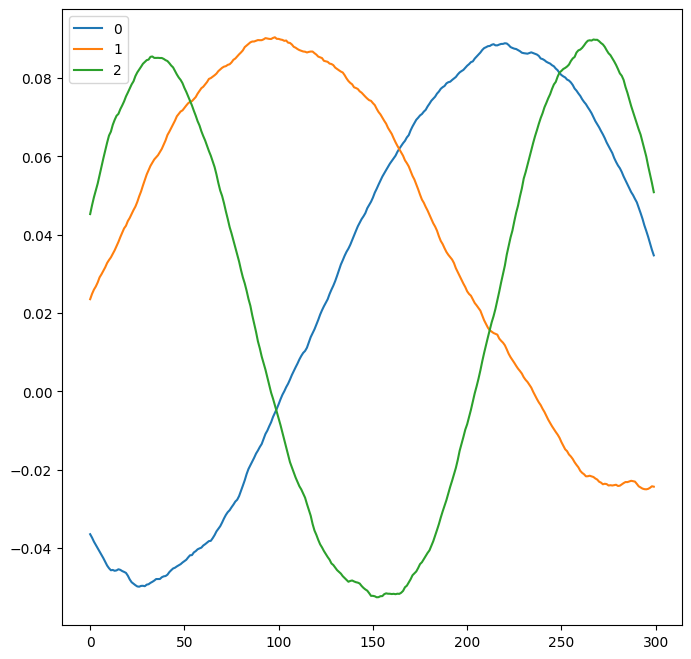

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

t = np.arange(pca.components_.shape[1])

components = [0, 1, 2]  # [0] + [i for i in range(299, 300)]

labels = list(map(str, components))
print(pca.components_.shape)

line_object = ax.plot(t, np.transpose(pca.components_[components, :]))
ax.legend(line_object, labels)
plt.show()

In [5]:
print(pca.noise_variance_)

0.0


In [6]:
from sklearn.cluster import KMeans

features = pca.components_[components, :]
km = KMeans(n_clusters=8)
labels = km.fit_predict(X_new)
clustered = km.fit_transform(X_new)

print(labels.shape)

(10000,)


In [7]:
print(X_new.shape)
print(clustered.shape)
print(features.shape)

(10000, 300)
(10000, 8)
(3, 300)


<IPython.core.display.Javascript object>


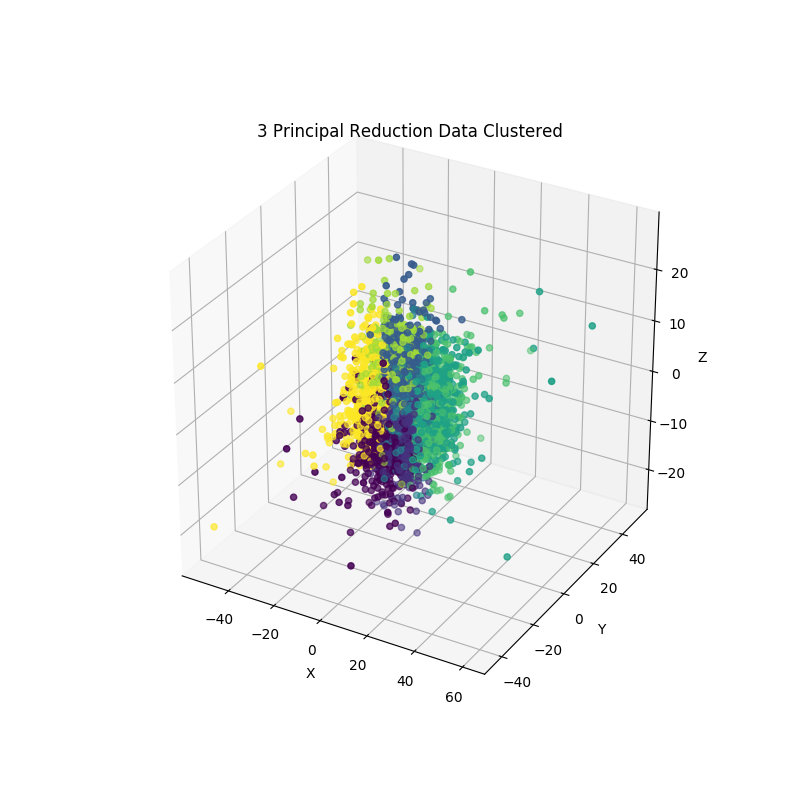

In [10]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_new[:,0], X_new[:,1], X_new[:,2], c=labels)
ax.set_title('3 Principal Reduction Data Clustered')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

<IPython.core.display.Javascript object>


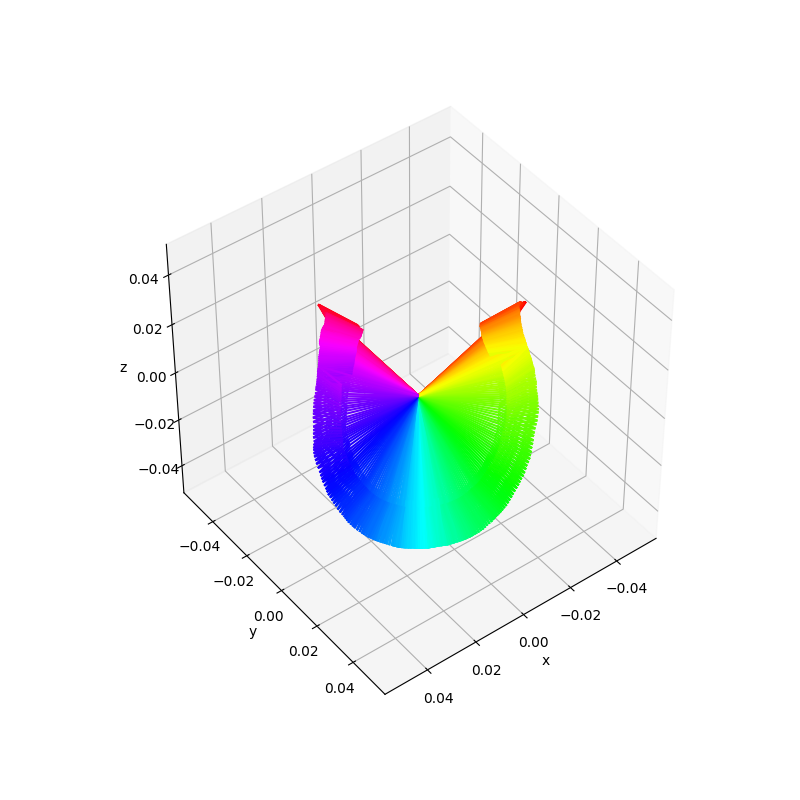

(300, 4)


In [11]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap('hsv')
colors = cmap(np.linspace(0, 1.0, features.shape[1]))
print(colors.shape)
num_eigenvec = features.shape[1]

for i in range(num_eigenvec):
    origin = [0,0,0]
    ax.quiver(*origin, 
              features[0,i], 
              features[1,i], 
              features[2,i], 
              length=0.05, 
              normalize=True, 
              pivot='tail', 
              color=colors[i,:])

# ax.set_title('3 Principal Components')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()